<a target="_blank" href="https://colab.research.google.com/github/ricocf/Leaflet-Product-Classification/blob/main/image_model/train_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Library Import and Setup**

In [ ]:
import os
import random
import shutil
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout

### **Data Preparation and Preprocessing**

In [ ]:
!wget https://zenodo.org/record/7869954/files/products_leaflets_256.zip
!unzip products_leaflets_256.zip

Streaming output truncated to the last 5000 lines.
  inflating: products_leaflets_256/train/738/39037.jpg  
  inflating: products_leaflets_256/train/738/39038.jpg  
  inflating: products_leaflets_256/train/738/39040.jpg  
  inflating: products_leaflets_256/train/738/39041.jpg  
  inflating: products_leaflets_256/train/738/39042.jpg  
  inflating: products_leaflets_256/train/738/39043.jpg  
  inflating: products_leaflets_256/train/738/39050.jpg  
  inflating: products_leaflets_256/train/738/39051.jpg  
  inflating: products_leaflets_256/train/738/39052.jpg  
  inflating: products_leaflets_256/train/738/39053.jpg  
  inflating: products_leaflets_256/train/738/39054.jpg  
  inflating: products_leaflets_256/train/738/39055.jpg  
  inflating: products_leaflets_256/train/738/39056.jpg  
  inflating: products_leaflets_256/train/738/39057.jpg  
  inflating: products_leaflets_256/train/738/39058.jpg  
  inflating: products_leaflets_256/train/738/39059.jpg  
  inflating: products_leaflets_256/tr

In [ ]:
# Setting up parameters and paths
num_classes = 832
root_directory = '/content/products_leaflets_256/train'
csv_filename = 'image_class_mapping.csv'

# Generating CSV mapping for images and classes
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_Name', 'Class_Name'])
    for class_folder in os.listdir(root_directory):
        class_path = os.path.join(root_directory, class_folder)
        if os.path.isdir(class_path):
            encoded_label = to_categorical(str(class_folder), num_classes=num_classes)
            for image_name in os.listdir(class_path):
                csv_writer.writerow([image_name, encoded_label])

# **Data Augmentation and CSV Modification**

In [ ]:
# Loading CSV file and modifying it
df = pd.read_csv('/content/image_class_mapping.csv')
df['Class_Name'] = df['Class_Name'].str.replace('.', '')
df.to_csv('modified_file.csv', index=False)
csv_filename = '/content/modified_file.csv'
df = pd.read_csv(csv_filename)
search_result = df[df['Image_Name'] == '500.jpg']
print("Search Result:")
print(search_result)

<ipython-input-5-a39ec39ba654>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Class_Name'] = df['Class_Name'].str.replace('.', '')


Search Result:
      Image_Name                                         Class_Name
25233    500.jpg  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0...


### **Data Splitting and Directory Operations**

**Data Preparation: Creating Validation Dataset and CSV Mapping**

In [ ]:
# Set the paths
test_data_path = '/content/products_leaflets_256/test'
validation_data_path = '/content/products_leaflets_256/validation'

os.makedirs(validation_data_path, exist_ok=True)
for subfolder in os.listdir(test_data_path):
    subfolder_path = os.path.join(test_data_path, subfolder)

    if os.path.isdir(subfolder_path):
        images = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        num_images_to_move = int(0.5 * len(images))
        images_to_move = random.sample(images, num_images_to_move)
        validation_subfolder_path = os.path.join(validation_data_path, subfolder)
        os.makedirs(validation_subfolder_path, exist_ok=True)

        # Move selected images to the validation subfolder
        for image_to_move in images_to_move:
            source_path = os.path.join(subfolder_path, image_to_move)
            destination_path = os.path.join(validation_subfolder_path, image_to_move)
            shutil.move(source_path, destination_path)

print("Validation dataset created successfully.")

num_classes = 832
# Path to the root directory containing the class folders (0-831)
root_directory = '/content/products_leaflets_256/validation'

csv_filename = 'validation_class_mapping.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Image_Name', 'Class_Name'])

    for class_folder in os.listdir(root_directory):
        class_path = os.path.join(root_directory, class_folder)
        if os.path.isdir(class_path):
            encoded_label = to_categorical(str(class_folder), num_classes=num_classes)
        for image_name in os.listdir(class_path):
          csv_writer.writerow([image_name,encoded_label])

df = pd.read_csv('/content/validation_class_mapping.csv')
df['Class_Name'] = df['Class_Name'].str.replace('.', '')
df.to_csv('validation_file.csv', index=False)


Validation dataset created successfully.


<ipython-input-6-11c4e865a0d7>:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Class_Name'] = df['Class_Name'].str.replace('.', '')


**Data Preprocessing: Moving Files and Cleaning Directories**

In [ ]:
train_folder = '/content/products_leaflets_256/train'
new_folder = '/content/products_leaflets_256/temp'

if not os.path.exists(new_folder):
    os.makedirs(new_folder)

for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            shutil.move(file_path, new_folder)

for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path):
        os.rmdir(subfolder_path)


**Data Preprocessing: Moving Validation Files, Cleaning Directories, and Shuffling DataFrame**

In [ ]:
train_folder = '/content/products_leaflets_256/validation'
new_folder = '/content/products_leaflets_256/tempvalid'

if not os.path.exists(new_folder):
    os.makedirs(new_folder)
for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            shutil.move(file_path, new_folder)

for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)
    if os.path.isdir(subfolder_path):
        os.rmdir(subfolder_path)

csv_file_path = '/content/modified_file.csv'
df = pd.read_csv(csv_file_path)
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_csv_file_path = '/content/train_shuffle.csv'
shuffled_df.to_csv(shuffled_csv_file_path, index=False)

# **Data Augmentation and Image Preprocessing**

*   Generators for Training and Validation Images



In [ ]:
# Load CSV file containing image paths and labels
csv_path = '/content/train_shuffle.csv'
csv_valid='/content/validation_file.csv'
df_train = pd.read_csv(csv_path)
df_valid = pd.read_csv(csv_valid)
train_image_dir = '/content/products_leaflets_256/temp'
val_image_dir='/content/products_leaflets_256/tempvalid'

# Define parameters for data augmentation and normalization
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Specify batch size and target size for your images
batch_size = 16
target_size = (224, 224)  # adjust based on model input size

train_temp_dir = '/content/train'
val_temp_dir = '/content/validation'
for temp_dir in [train_temp_dir, val_temp_dir]:
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

train_generator = datagen.flow_from_dataframe(
    df_train,  # DataFrame for training data
    directory=train_image_dir,
    x_col='Image_Name',
    y_col='Class_Name',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    save_to_dir=train_temp_dir,
    save_prefix='aug_train',
    save_format='jpeg'
)

# Create a generator for validation images from the DataFrame
val_generator = datagen.flow_from_dataframe(
    df_valid,  # DataFrame for validation data
    directory=val_image_dir,
    x_col='Image_Name',
    y_col='Class_Name',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    save_to_dir=val_temp_dir,
    save_prefix='aug_val',
    save_format='jpeg'
)


Found 33280 validated image filenames belonging to 832 classes.
Found 4160 validated image filenames belonging to 832 classes.


# **Model Building**

In [ ]:
# Defining the model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 832)               852800    
                                                                 
Total params: 26538688 (101.24 MB)
Trainable params: 26485568 (101.03 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.95)
model.compile(optimizer=sgd_optimizer ,loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/15
2080/2080 [==============================] - 458s 208ms/step - loss: 2.0235 - accuracy: 0.6625 - val_loss: 0.6620 - val_accuracy: 0.8565
Epoch 2/15
2080/2080 [==============================] - 414s 199ms/step - loss: 0.1670 - accuracy: 0.9620 - val_loss: 0.5824 - val_accuracy: 0.8779
Epoch 3/15
2080/2080 [==============================] - 413s 199ms/step - loss: 0.0586 - accuracy: 0.9853 - val_loss: 0.5301 - val_accuracy: 0.8952
Epoch 4/15
2080/2080 [==============================] - 417s 201ms/step - loss: 0.0290 - accuracy: 0.9934 - val_loss: 0.4716 - val_accuracy: 0.9103
Epoch 5/15
2080/2080 [==============================] - 419s 201ms/step - loss: 0.0144 - accuracy: 0.9968 - val_loss: 0.4626 - val_accuracy: 0.9130
Epoch 6/15
2080/2080 [==============================] - 416s 200ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.4516 - val_accuracy: 0.9144
Epoch 7/15
2080/2080 [==============================] - 421s 203ms/step - loss: 0.0069 - accuracy: 0.9986 - val_

# **Model Evaluation and Saving**

*   Training & validation accuracy
*   Training & validation loss



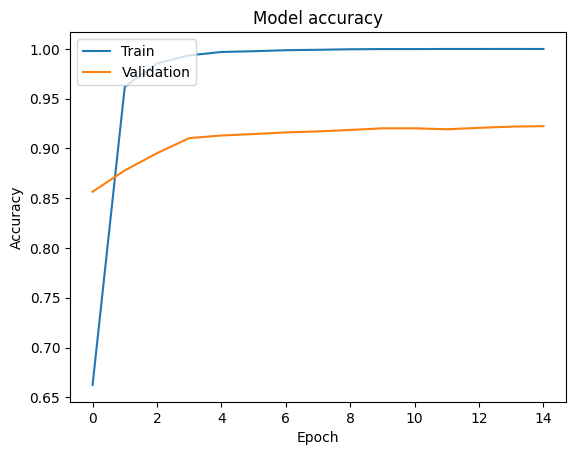

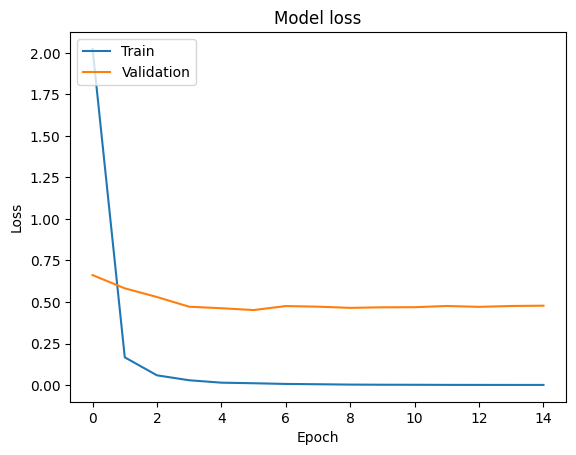

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**Distribution of Maximum Prediction Probabilities**

260/261 [============================>.] - ETA: 0s

261/261 [==============================] - 33s 120ms/step


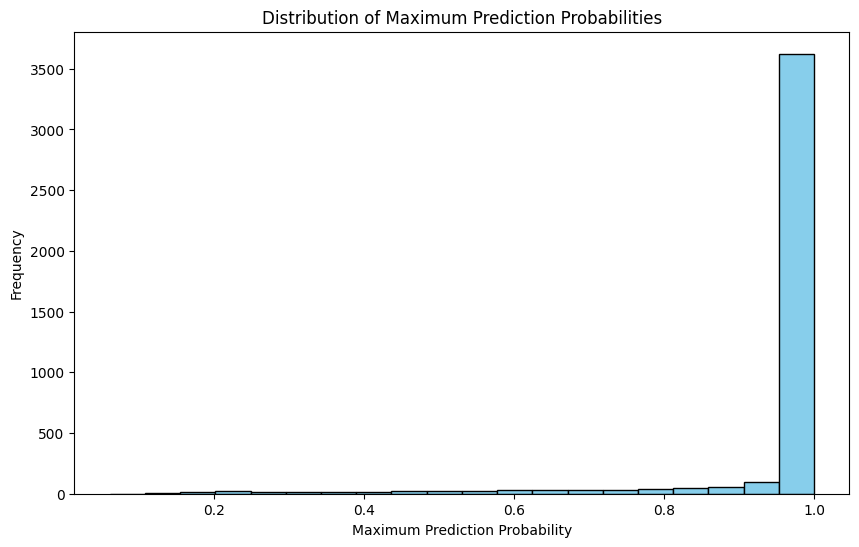

In [ ]:
# Compute prediction probabilities for each class
prediction_probabilities = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)

# Get the maximum probability for each prediction
max_probabilities = np.max(prediction_probabilities, axis=1)

# Plotting the distribution of maximum prediction probabilities
plt.figure(figsize=(10, 6))
plt.hist(max_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Maximum Prediction Probabilities')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Frequency')
plt.show()

**Bar plot of top misclassifications**

260/261 [============================>.] - ETA: 0s

261/261 [==============================] - 28s 106ms/step


<ipython-input-20-f7731b701e49>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=[f'{true}->{pred}' for true, pred, _ in confusion_pairs],


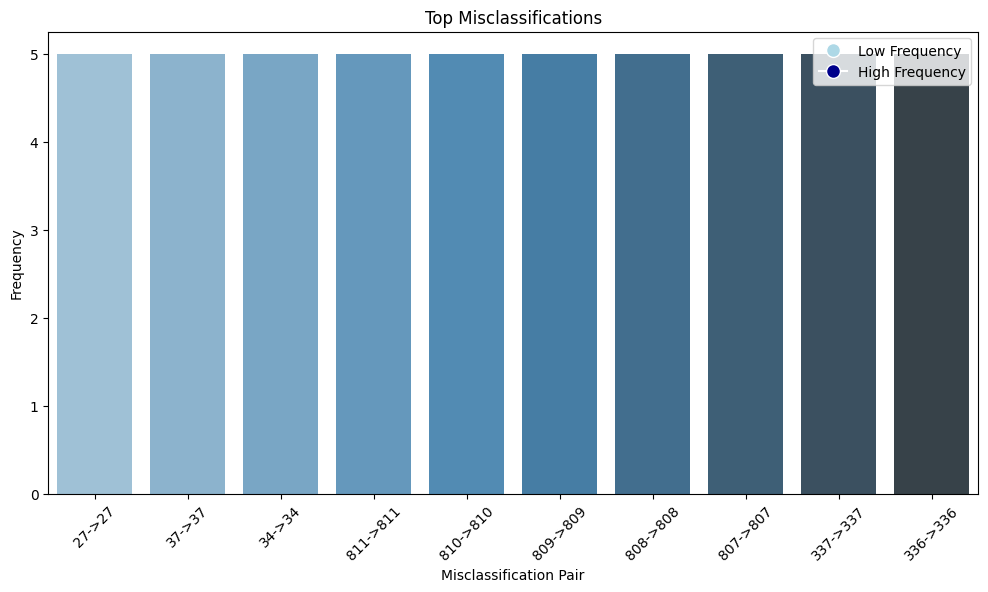

In [ ]:
val_generator.reset()
y_pred = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_true = val_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)


top_misclassifications = np.argsort(-conf_matrix, axis=None)[:10]
top_misclassifications_counts = conf_matrix.flatten()[top_misclassifications]

class_labels = [str(i) for i in range(num_classes)]
confusion_pairs = [(class_labels[i // num_classes], class_labels[i % num_classes], count)
                   for i, count in zip(top_misclassifications, top_misclassifications_counts)]

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=[f'{true}->{pred}' for true, pred, _ in confusion_pairs],
                       y=[count for _, _, count in confusion_pairs], palette="Blues_d")

colors = ['lightblue', 'darkblue']  # Adjust colors based on the palette
legend_labels = ['Low Frequency', 'High Frequency']
legend = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                     markerfacecolor=color, label=label) for color, label in zip(colors, legend_labels)]
plt.legend(handles=legend, loc='upper right')

plt.title('Top Misclassifications')
plt.xlabel('Misclassification Pair')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [ ]:
model.save('trained_model_tf')
!zip -r /content/trained_model.zip /content/trained_model_tf
print("Model Saved!")

  adding: content/trained_model_tf/ (stored 0%)
  adding: content/trained_model_tf/assets/ (stored 0%)
  adding: content/trained_model_tf/saved_model.pb (deflated 91%)
  adding: content/trained_model_tf/variables/ (stored 0%)
  adding: content/trained_model_tf/variables/variables.index (deflated 78%)
  adding: content/trained_model_tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/trained_model_tf/keras_metadata.pb (deflated 96%)
  adding: content/trained_model_tf/fingerprint.pb (stored 0%)
Model Saved!
